In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
folder_path = 'images/'
covid = 'images/COVID/'
normal = 'images/NORMAL/'

num_classes = 3

X = []
Y = []

In [3]:
list(enumerate([normal, covid]))

[(0, 'images/NORMAL/'), (1, 'images/COVID/')]

In [4]:
for class_label, folder_path in enumerate([normal, covid]):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png')):
            file_path = os.path.join(folder_path, filename)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (200, 200))
            if image is not None:
                X.append(image)
                Y.append(class_label)

In [5]:
print(type(X), type(Y))
print(len(X), len(Y))

<class 'list'> <class 'list'>
3428 3428


In [6]:
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(3428, 200, 200, 3) (3428,)


In [7]:
shuffle_indices = np.arange(len(X))
np.random.shuffle(shuffle_indices)

X = X[shuffle_indices]
Y = Y[shuffle_indices]

print(X.shape, Y.shape)

(3428, 200, 200, 3) (3428,)


### Creating H5 file

In [8]:
import h5py

h5_file = 'h5_file.h5'
i = 0
with h5py.File(h5_file, 'w') as hdf5_file:
    image_dataset = hdf5_file.create_dataset("images", (3439, 200, 200, 3), dtype='uint8')
    label_dataset = hdf5_file.create_dataset("labels", (3439,), dtype='int')
    image_indices = np.arange(3439)
    for class_label, folder_path in enumerate([normal, covid]):
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png')):
                file_path = os.path.join(folder_path, filename)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (200, 200))
                if image is not None:
                    index = image_indices[i]
                    image_dataset[index] = image
                    label_dataset[index] = class_label
                    i += 1

In [9]:
with h5py.File(h5_file, "r") as hdf5_file:
    X = hdf5_file["images"][:]
    Y = hdf5_file["labels"][:]

print(X.shape, Y.shape)

(3439, 200, 200, 3) (3439,)


### Spliting data

In [10]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(2751, 200, 200, 3) (2751,)
(413, 200, 200, 3) (413,)
(275, 200, 200, 3) (275,)


0


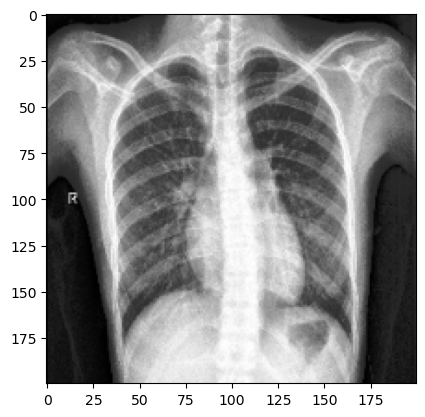

In [11]:
image = X[10]
print(Y[10])
plt.imshow(image)

## Data Dataset

In [12]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(buffer_size=100)

dataset

2023-11-28 13:19:57.653887: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-28 13:19:57.653934: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-28 13:19:57.653944: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-28 13:19:57.654049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 13:19:57.655073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<_ShuffleDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## ResNet50

In [14]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
resnet_model

for layer in resnet_model.layers:
  layer.trainable = False

resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

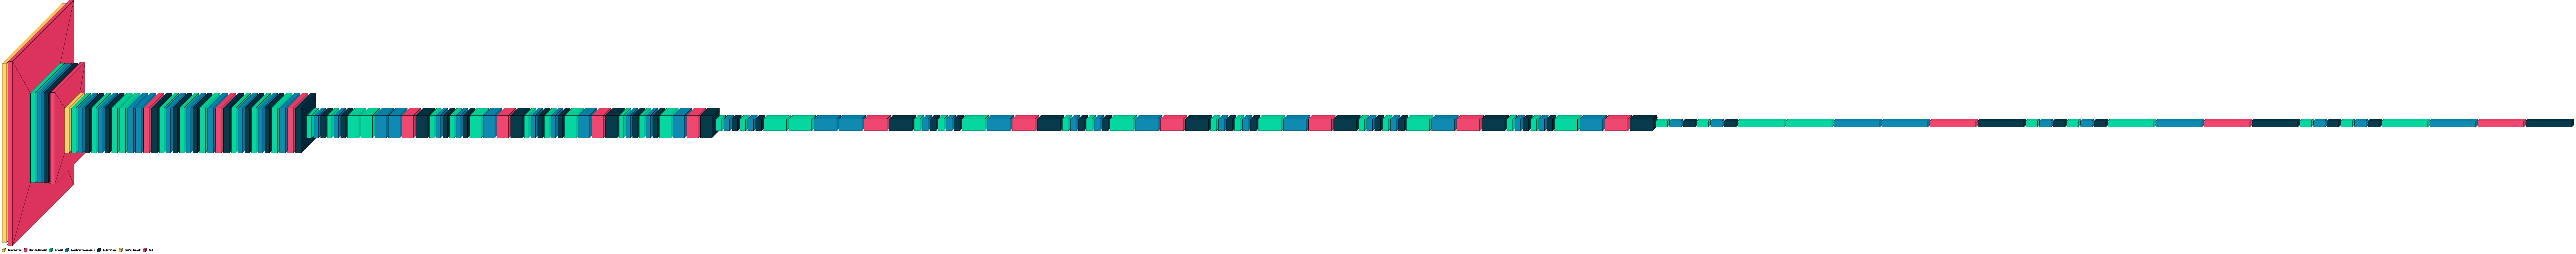

In [15]:
import visualkeras
visualkeras.layered_view(resnet_model, legend=True)

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # Horizontal flip
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.17),  # Random rotation up to 30 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15),  # Random zoom up to 15%
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=.2, width_factor=.2),  # Random shear up to 20%
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0, input_shape=(200, 200, 3))
])

In [17]:
transfer_model = Sequential()

transfer_model.add(data_augmentation)
transfer_model.add(resnet_model)

transfer_model.add(GlobalAveragePooling2D())
transfer_model.add(Dense(512, activation = 'relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(512, activation = 'relu'))
transfer_model.add(Dropout(0.5))

transfer_model.add(Dense(1, activation = 'sigmoid'))

#transfer_model.build((None,200,200,3))
#transfer_model.summary()

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

In [19]:
epochs = 30
history = transfer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=64, verbose=2)

Epoch 1/30


2023-11-28 13:25:09.842220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-28 13:25:10.270488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:25:19.164775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:25:19.738307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:25:20.146672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:25:20.540941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28

43/43 - 52s - loss: 0.4088 - accuracy: 0.5089 - val_loss: 0.2733 - val_accuracy: 0.4036 - 52s/epoch - 1s/step
Epoch 2/30


2023-11-28 13:26:00.500048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:01.518154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:01.964950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:02.424566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:02.845838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:03.292491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 23s - loss: 0.4393 - accuracy: 0.5067 - val_loss: 0.3185 - val_accuracy: 0.4000 - 23s/epoch - 539ms/step
Epoch 3/30


2023-11-28 13:26:23.599249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:24.064069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:24.470736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:24.882901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:25.297202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:25.706730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.4195 - accuracy: 0.5249 - val_loss: 0.2655 - val_accuracy: 0.6109 - 22s/epoch - 505ms/step
Epoch 4/30


2023-11-28 13:26:45.328990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:45.803911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:46.220697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:46.632653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:47.053956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:26:47.457451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.3922 - accuracy: 0.5398 - val_loss: 0.1493 - val_accuracy: 0.7636 - 22s/epoch - 504ms/step
Epoch 5/30


2023-11-28 13:27:07.009847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:07.475642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:07.903293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:08.321034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:08.734750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:09.215490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.3393 - accuracy: 0.5896 - val_loss: 0.1963 - val_accuracy: 0.6109 - 22s/epoch - 507ms/step
Epoch 6/30


2023-11-28 13:27:28.808094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:29.250848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:29.669057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:30.101075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:30.538472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:30.949787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.3280 - accuracy: 0.6060 - val_loss: 0.2005 - val_accuracy: 0.6109 - 22s/epoch - 510ms/step
Epoch 7/30


2023-11-28 13:27:50.752350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:51.206136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:51.627322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:52.044962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:52.468633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:27:52.861628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.3473 - accuracy: 0.5881 - val_loss: 0.1421 - val_accuracy: 0.7600 - 21s/epoch - 497ms/step
Epoch 8/30


2023-11-28 13:28:12.137654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:12.586956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:12.999125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:13.420021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:13.847448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:14.252602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.2648 - accuracy: 0.6787 - val_loss: 0.1277 - val_accuracy: 0.8182 - 21s/epoch - 497ms/step
Epoch 9/30


2023-11-28 13:28:33.516212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:34.092400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:34.504606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:34.915219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:35.317910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:35.733808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.2554 - accuracy: 0.6798 - val_loss: 0.1468 - val_accuracy: 0.7600 - 22s/epoch - 510ms/step
Epoch 10/30


2023-11-28 13:28:55.466766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:56.071700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:56.493183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:56.901640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:57.308676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:28:57.723251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 23s - loss: 0.2362 - accuracy: 0.6983 - val_loss: 0.0895 - val_accuracy: 0.9018 - 23s/epoch - 527ms/step
Epoch 11/30


2023-11-28 13:29:18.114477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:18.568592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:18.996852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:19.400136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:19.806701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:20.212502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.2175 - accuracy: 0.7205 - val_loss: 0.1124 - val_accuracy: 0.8618 - 21s/epoch - 478ms/step
Epoch 12/30


2023-11-28 13:29:38.667799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:39.299435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:39.713802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:40.122177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:40.528436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:40.927807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.2013 - accuracy: 0.7441 - val_loss: 0.0901 - val_accuracy: 0.9018 - 21s/epoch - 478ms/step
Epoch 13/30


2023-11-28 13:29:59.236726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:29:59.678334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:00.080265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:00.496242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:00.896715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:01.304437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.1887 - accuracy: 0.7703 - val_loss: 0.0923 - val_accuracy: 0.8982 - 22s/epoch - 521ms/step
Epoch 14/30


2023-11-28 13:30:21.657903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:22.300902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:22.762348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:23.185797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:23.628664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:24.081604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 20s - loss: 0.2172 - accuracy: 0.7226 - val_loss: 0.1074 - val_accuracy: 0.8655 - 20s/epoch - 463ms/step
Epoch 15/30


2023-11-28 13:30:41.594540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:42.047570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:42.460381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:42.861059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:43.264389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:30:43.661770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.1788 - accuracy: 0.7815 - val_loss: 0.1121 - val_accuracy: 0.8618 - 21s/epoch - 497ms/step
Epoch 16/30


2023-11-28 13:31:03.035926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:03.490658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:03.930210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:04.345011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:04.748869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:05.168153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.1853 - accuracy: 0.7706 - val_loss: 0.0691 - val_accuracy: 0.9091 - 21s/epoch - 494ms/step
Epoch 17/30


2023-11-28 13:31:24.281217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:24.746648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:25.163373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:25.580684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:25.988265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:26.394552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.1809 - accuracy: 0.7739 - val_loss: 0.0787 - val_accuracy: 0.9127 - 21s/epoch - 491ms/step
Epoch 18/30


2023-11-28 13:31:45.404705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:45.836552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:46.252836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:46.649504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:47.060100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:31:47.466151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.1610 - accuracy: 0.8023 - val_loss: 0.1460 - val_accuracy: 0.7855 - 22s/epoch - 512ms/step
Epoch 19/30


2023-11-28 13:32:07.425733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:07.871957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:08.279732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:08.697520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:09.116217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:09.520033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 20s - loss: 0.1664 - accuracy: 0.7979 - val_loss: 0.0784 - val_accuracy: 0.9091 - 20s/epoch - 465ms/step
Epoch 20/30


2023-11-28 13:32:27.442199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:27.880463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:28.293256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:28.711457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:29.126269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:29.536870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.1550 - accuracy: 0.8099 - val_loss: 0.0813 - val_accuracy: 0.9091 - 22s/epoch - 511ms/step
Epoch 21/30


2023-11-28 13:32:49.434407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:49.896608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:50.321496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:50.739466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:51.151947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:32:51.559696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 20s - loss: 0.1608 - accuracy: 0.7979 - val_loss: 0.1259 - val_accuracy: 0.8327 - 20s/epoch - 464ms/step
Epoch 22/30


2023-11-28 13:33:09.413886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:09.855706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:10.272867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:10.696429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:11.095782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:11.505250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.1687 - accuracy: 0.7910 - val_loss: 0.0790 - val_accuracy: 0.9091 - 21s/epoch - 485ms/step
Epoch 23/30


2023-11-28 13:33:30.283555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:30.756210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:31.159846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:31.571069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:31.986035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:32.385969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.1510 - accuracy: 0.8161 - val_loss: 0.0795 - val_accuracy: 0.9091 - 22s/epoch - 504ms/step
Epoch 24/30


2023-11-28 13:33:51.973273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:52.432731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:52.832831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:53.226268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:53.666075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:33:54.057327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.1572 - accuracy: 0.8070 - val_loss: 0.0992 - val_accuracy: 0.8836 - 21s/epoch - 490ms/step
Epoch 25/30


2023-11-28 13:34:13.071179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:13.544907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:13.960967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:14.386646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:14.811300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:15.213471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.1704 - accuracy: 0.7917 - val_loss: 0.0803 - val_accuracy: 0.9091 - 21s/epoch - 479ms/step
Epoch 26/30


2023-11-28 13:34:33.682372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:34.158988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:34.580570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:35.004352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:35.412217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:35.822700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 22s - loss: 0.1749 - accuracy: 0.7841 - val_loss: 0.0749 - val_accuracy: 0.9127 - 22s/epoch - 515ms/step
Epoch 27/30


2023-11-28 13:34:55.839753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:56.321509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:56.779099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:57.252340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:57.685197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:34:58.129871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 20s - loss: 0.1622 - accuracy: 0.7961 - val_loss: 0.2141 - val_accuracy: 0.6982 - 20s/epoch - 476ms/step
Epoch 28/30


2023-11-28 13:35:16.321227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:16.801664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:17.228891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:17.638292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:18.054833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:18.457049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 20s - loss: 0.1796 - accuracy: 0.7801 - val_loss: 0.0927 - val_accuracy: 0.8909 - 20s/epoch - 470ms/step
Epoch 29/30


2023-11-28 13:35:36.561319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:37.026994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:37.439184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:37.869976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:38.306991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:38.746791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 21s - loss: 0.1595 - accuracy: 0.8084 - val_loss: 0.1154 - val_accuracy: 0.8618 - 21s/epoch - 488ms/step
Epoch 30/30


2023-11-28 13:35:57.553115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:58.061721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:58.500676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:58.961821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:59.454362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:35:59.981094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/43 - 26s - loss: 0.1655 - accuracy: 0.7983 - val_loss: 0.1176 - val_accuracy: 0.8618 - 26s/epoch - 596ms/step


In [20]:
test_loss, test_acc = transfer_model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

13/13 - 22s - loss: 0.1107 - accuracy: 0.8329 - 22s/epoch - 2s/step

Test accuracy: 0.832929790019989


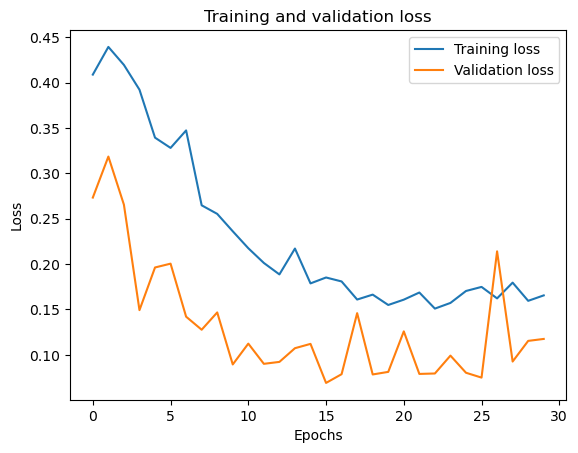

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(0, epochs), history.history['loss'], label = 'Training loss')
plt.plot(range(0, epochs), history.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

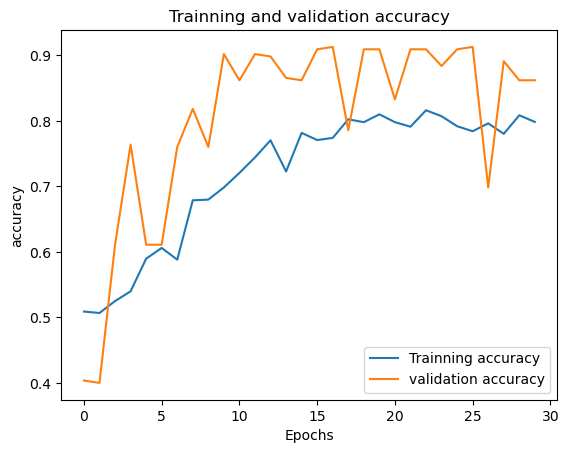

In [22]:
plt.plot(range(0, epochs), history.history['accuracy'], label = 'Trainning accuracy')
plt.plot(range(0, epochs), history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Trainning and validation accuracy')
plt.legend()

## MobileNet

In [23]:
mobileNet_model = keras.applications.MobileNet(weights='imagenet', include_top = False, input_shape=(200,200,3))

#Avoid retrain
for layer in mobileNet_model.layers:
  layer.trainable = False

mobileNet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 100, 100, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 100, 100, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 100, 100, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 100, 100, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 100, 100, 32

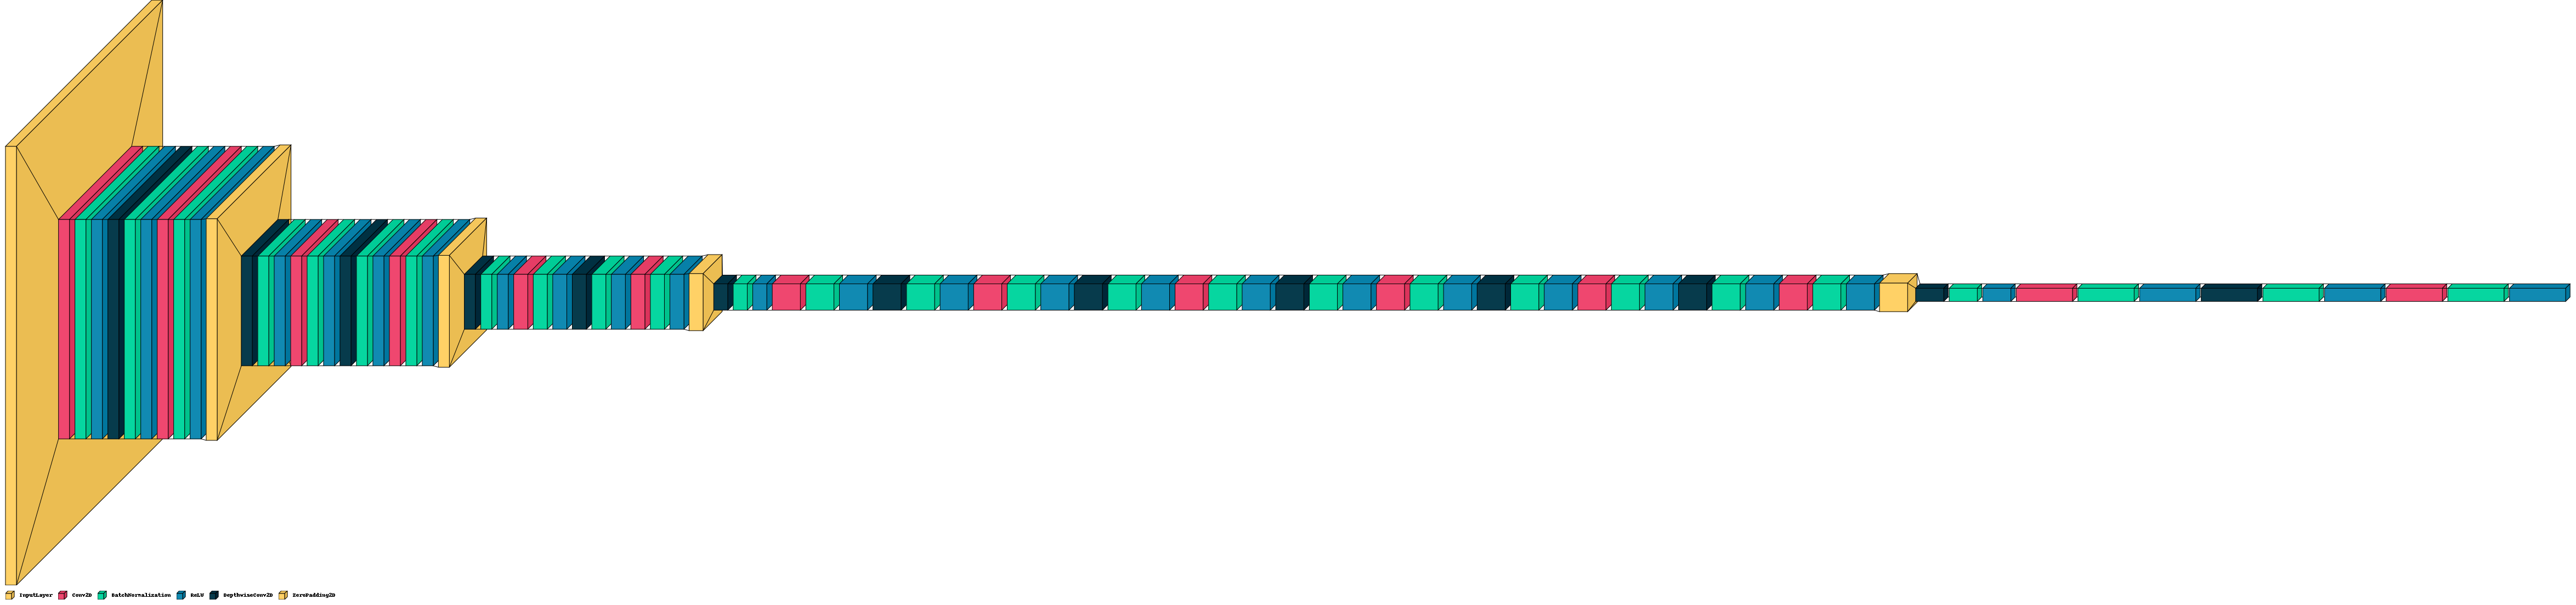

In [24]:
visualkeras.layered_view(mobileNet_model, legend=True)

In [25]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # Horizontal flip
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.17),  # Random rotation up to 30 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15),  # Random zoom up to 15%
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=.2, width_factor=.2),  # Random shear up to 20%
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0, input_shape=(200, 200, 3))
])

In [26]:
new_model = Sequential()

new_model.add(data_augmentation)
new_model.add(mobileNet_model)


new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(120, activation = "relu"))
new_model.add(Dense(120, activation = "relu"))
new_model.add(Dropout(0.5))
new_model.add(Dense(1, activation="sigmoid"))

#new_model.summary()
#new_model.build((None,200,200,3))

new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy'),
                           metrics = ['accuracy'])

In [28]:
epochs = 20
new_model_history = new_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=epochs, batch_size=32, verbose=2)

Epoch 1/20


2023-11-28 13:39:13.632996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-28 13:39:14.396348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:22.559554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:22.796359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:22.931233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:23.040600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28

86/86 - 35s - loss: 0.2680 - accuracy: 0.9149 - val_loss: 0.1294 - val_accuracy: 0.9709 - 35s/epoch - 409ms/step
Epoch 2/20


2023-11-28 13:39:45.226902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:45.459993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:45.561499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:45.659802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:45.762836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:45.861978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.1176 - accuracy: 0.9698 - val_loss: 0.1689 - val_accuracy: 0.9527 - 10s/epoch - 119ms/step
Epoch 3/20


2023-11-28 13:39:55.438704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:55.570410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:55.689189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:55.794957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:55.895273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:39:55.995701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.1235 - accuracy: 0.9651 - val_loss: 0.1117 - val_accuracy: 0.9709 - 10s/epoch - 121ms/step
Epoch 4/20


2023-11-28 13:40:06.031850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:06.467669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:06.710284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:07.003112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:07.113758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:07.210029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 11s - loss: 0.0953 - accuracy: 0.9727 - val_loss: 0.0722 - val_accuracy: 0.9782 - 11s/epoch - 123ms/step
Epoch 5/20


2023-11-28 13:40:16.565064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:16.708077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:16.834100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:16.945596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:17.050983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:17.152148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0790 - accuracy: 0.9782 - val_loss: 0.0613 - val_accuracy: 0.9782 - 10s/epoch - 114ms/step
Epoch 6/20


2023-11-28 13:40:26.404245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:26.530181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:26.635465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:26.740541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:26.841925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:26.947121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0779 - accuracy: 0.9760 - val_loss: 0.0982 - val_accuracy: 0.9709 - 10s/epoch - 117ms/step
Epoch 7/20


2023-11-28 13:40:36.495647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:36.639739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:36.748654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:36.846257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:36.952320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:37.059281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0696 - accuracy: 0.9807 - val_loss: 0.1107 - val_accuracy: 0.9709 - 10s/epoch - 118ms/step
Epoch 8/20


2023-11-28 13:40:46.613443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:46.770523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:46.895768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:47.001196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:47.109744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:47.211112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0644 - accuracy: 0.9800 - val_loss: 0.0856 - val_accuracy: 0.9745 - 10s/epoch - 113ms/step
Epoch 9/20


2023-11-28 13:40:56.368908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:56.525175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:56.628012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:56.734708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:56.832435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:40:56.932605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0670 - accuracy: 0.9807 - val_loss: 0.1967 - val_accuracy: 0.9491 - 10s/epoch - 112ms/step
Epoch 10/20


2023-11-28 13:41:05.994123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:06.111311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:06.215035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:06.332092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:06.436744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:06.569684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0756 - accuracy: 0.9786 - val_loss: 0.0341 - val_accuracy: 0.9891 - 9s/epoch - 110ms/step
Epoch 11/20


2023-11-28 13:41:15.425252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:15.550542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:15.660544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:15.762676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:15.862703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:15.960236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0637 - accuracy: 0.9818 - val_loss: 0.1269 - val_accuracy: 0.9673 - 10s/epoch - 112ms/step
Epoch 12/20


2023-11-28 13:41:25.041715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:25.166883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:25.267900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:25.368559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:25.468577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:25.566327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0670 - accuracy: 0.9796 - val_loss: 0.0619 - val_accuracy: 0.9782 - 9s/epoch - 107ms/step
Epoch 13/20


2023-11-28 13:41:34.279666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:34.387184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:34.484858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:34.606453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:34.702320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:34.802229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0503 - accuracy: 0.9844 - val_loss: 0.1639 - val_accuracy: 0.9600 - 9s/epoch - 104ms/step
Epoch 14/20


2023-11-28 13:41:43.253009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:43.404209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:43.498494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:43.593575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:43.688315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:43.789546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0605 - accuracy: 0.9844 - val_loss: 0.1156 - val_accuracy: 0.9709 - 10s/epoch - 115ms/step
Epoch 15/20


2023-11-28 13:41:53.103884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:53.215901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:53.353432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:53.473370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:53.587585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:41:53.699505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0575 - accuracy: 0.9829 - val_loss: 0.0438 - val_accuracy: 0.9818 - 9s/epoch - 107ms/step
Epoch 16/20


2023-11-28 13:42:02.346546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:02.449337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:02.543560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:02.635265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:02.730297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:02.830032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0535 - accuracy: 0.9815 - val_loss: 0.0885 - val_accuracy: 0.9745 - 9s/epoch - 108ms/step
Epoch 17/20


2023-11-28 13:42:11.682873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:11.946426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:12.071500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:12.191632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:12.301985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:12.400151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 10s - loss: 0.0773 - accuracy: 0.9782 - val_loss: 0.0869 - val_accuracy: 0.9745 - 10s/epoch - 112ms/step
Epoch 18/20


2023-11-28 13:42:21.269154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:21.391046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:21.502137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:21.608228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:21.707102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:21.801642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0463 - accuracy: 0.9858 - val_loss: 0.0451 - val_accuracy: 0.9818 - 9s/epoch - 110ms/step
Epoch 19/20


2023-11-28 13:42:30.707695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:30.814046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:30.907428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:31.002163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:31.101013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:31.195181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0582 - accuracy: 0.9833 - val_loss: 0.2153 - val_accuracy: 0.9455 - 9s/epoch - 101ms/step
Epoch 20/20


2023-11-28 13:42:39.427428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:39.537005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:39.631927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:39.724004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:39.817543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 13:42:39.918649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

86/86 - 9s - loss: 0.0578 - accuracy: 0.9811 - val_loss: 0.3355 - val_accuracy: 0.9418 - 9s/epoch - 106ms/step


In [29]:
test_loss, test_acc = new_model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

13/13 - 9s - loss: 0.2214 - accuracy: 0.9370 - 9s/epoch - 701ms/step

Test accuracy: 0.9370459914207458


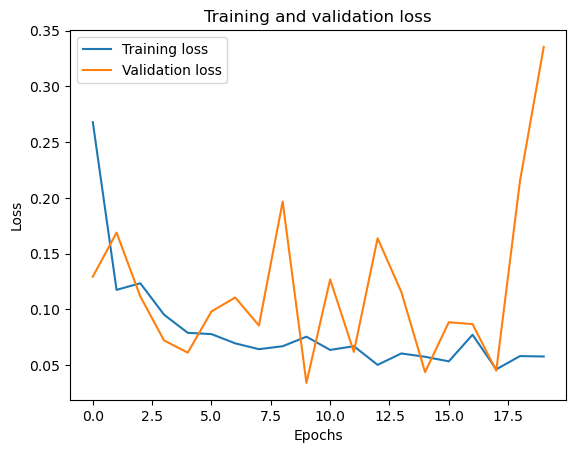

In [30]:
plt.plot(range(0, epochs), new_model_history.history['loss'], label = 'Training loss')
plt.plot(range(0, epochs), new_model_history.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

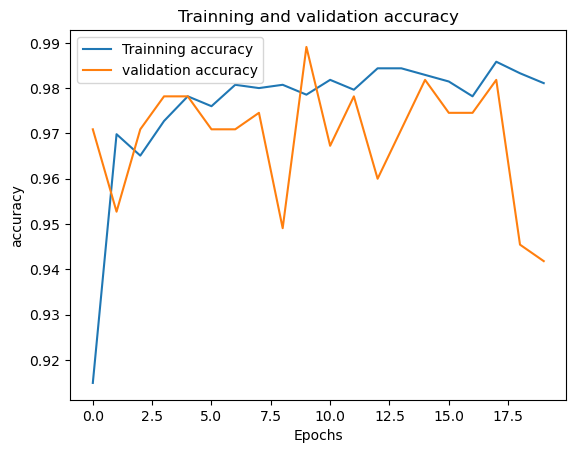

In [31]:
plt.plot(range(0, epochs), new_model_history.history['accuracy'], label = 'Trainning accuracy')
plt.plot(range(0, epochs), new_model_history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Trainning and validation accuracy')
plt.legend()

In [32]:
def binary_conversion(y_val, lim=0.5):

  for i in range(len(y_val)):
    if y_val[i] >= lim:
        y_val[i] = 1
    else:
        y_val[i] = 0
  y_val = np.squeeze(y_val)
  return y_val.astype(int)

In [33]:
y_pred = new_model.predict(X_val, verbose=1)
y_pred = binary_conversion(y_pred)
print(y_pred.shape, y_val.shape)

2023-11-28 14:19:05.860519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 395ms/step
(275,) (275,)


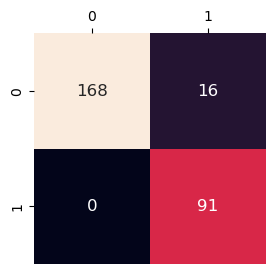

In [34]:
import seaborn as sb

matrix = confusion_matrix(y_pred, y_val)
plt.figure(figsize = (3,3))
ax = sb.heatmap(matrix, annot=True, fmt='g', annot_kws={"size": 12}, cbar=False) # font size
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()


In [36]:
reporte = classification_report(y_pred, y_val, labels=[0,1])
print(reporte)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       184
           1       0.85      1.00      0.92        91

    accuracy                           0.94       275
   macro avg       0.93      0.96      0.94       275
weighted avg       0.95      0.94      0.94       275

